Load modules

In [1]:
import spacy
from torchtext.datasets import Multi30k
from torchtext.data import Field
import torch
from torch import nn
from torchtext.data import BucketIterator
import torch.optim as optim
import random
import time

Dataset


code source : https://tutorials.pytorch.kr/beginner/torchtext_translation_tutorial.html

In [2]:
!python -m spacy download en
!python -m spacy download de
SRC = Field(tokenize = "spacy",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize = "spacy",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

# Download dataset
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),
                                                    fields = (SRC, TRG))

# Use vocab with minimum frequency 2
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128

# Construct Iterater
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device)

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 14.9MB 9.0MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907057 sha256=98a12147bfbff5b5c97b5490b10c0a4ad63f4ef80071fefbb24eb475fdb2048a
  Stored in directory: /tmp/pip-ephem-wheel-cache-wyf2c5wm/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')
downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 654kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 174kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 163kB/s]


Look up dataset

In [3]:
for sample in train_data:
  print(f'SRC : {sample.src}')
  print(f'TRG : {sample.trg}')
  break

SRC : ['zwei', 'junge', 'weiße', 'männer', 'sind', 'i', 'm', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']
TRG : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


In [4]:
for batch in train_iterator:
  print(f'SRC shape : {batch.src.shape}')
  print(f'TRG shape : {batch.trg.shape}')
  break

SRC shape : torch.Size([31, 128])
TRG shape : torch.Size([31, 128])


Hyper paramter

In [5]:
# BATCH_SIZE = 128
N_EPOCH = 20
LR = 1e-4
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENCODER_EMBED_DIM = 256
DECODER_EMBED_DIM = 256
HIDDEN_DIM = 512
N_LAYERS = 2
ENC_DROPOUT_RATIO = 0.5
DEC_DROPOUT_RATIO = 0.5
CLIP = 1

Encoder
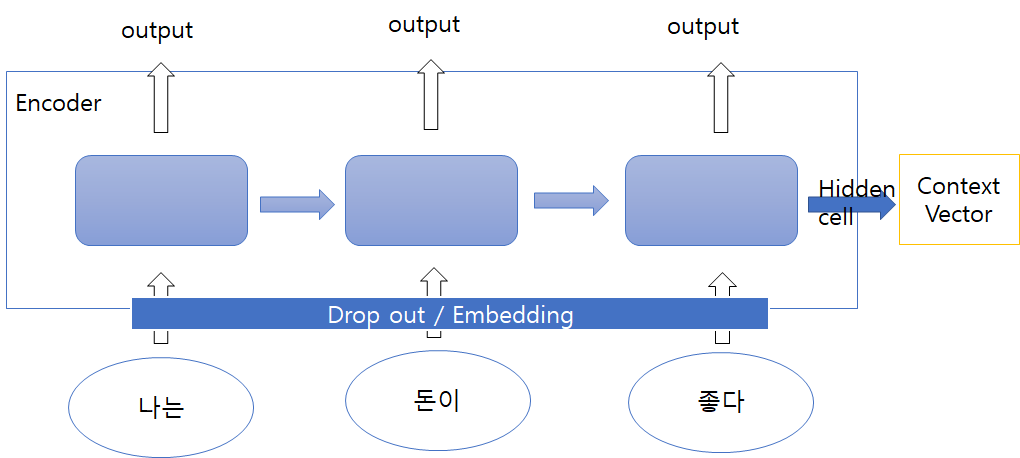

In [6]:
class Encoder(nn.Module):
  def __init__(self,in_dim, emb_dim, hid_dim, n_layers, drop_rate):
    super(Encoder, self).__init__()
    # arguments
    self.in_dim = in_dim
    self.emb_dim = emb_dim
    self.hid_dim = hid_dim
    self.n_layers = n_layers
    self.drop_rate = drop_rate
    # layers
    self.emb = nn.Embedding(self.in_dim, self.emb_dim)
    self.lstm = nn.LSTM(input_size = emb_dim,
                        hidden_size = hid_dim,
                        num_layers = n_layers,
                        batch_first = False,
                        dropout = self.drop_rate)
    self.dropout = nn.Dropout(self.drop_rate)

  def forward(self, src):    
    embedded = self.dropout(self.emb(src))    
    outputs, (hidden, cell) = self.lstm(embedded)    # lstm retunrs not only hidden state but also cell state
    # outputs shpae : [num words, batch size, hidden dim]
    # hidden state shape : [n layers, batch size, hidden dim]
    # cell state shape: [n layers, batch size, hidden dim]
    return hidden, cell    # context vector

Decoder

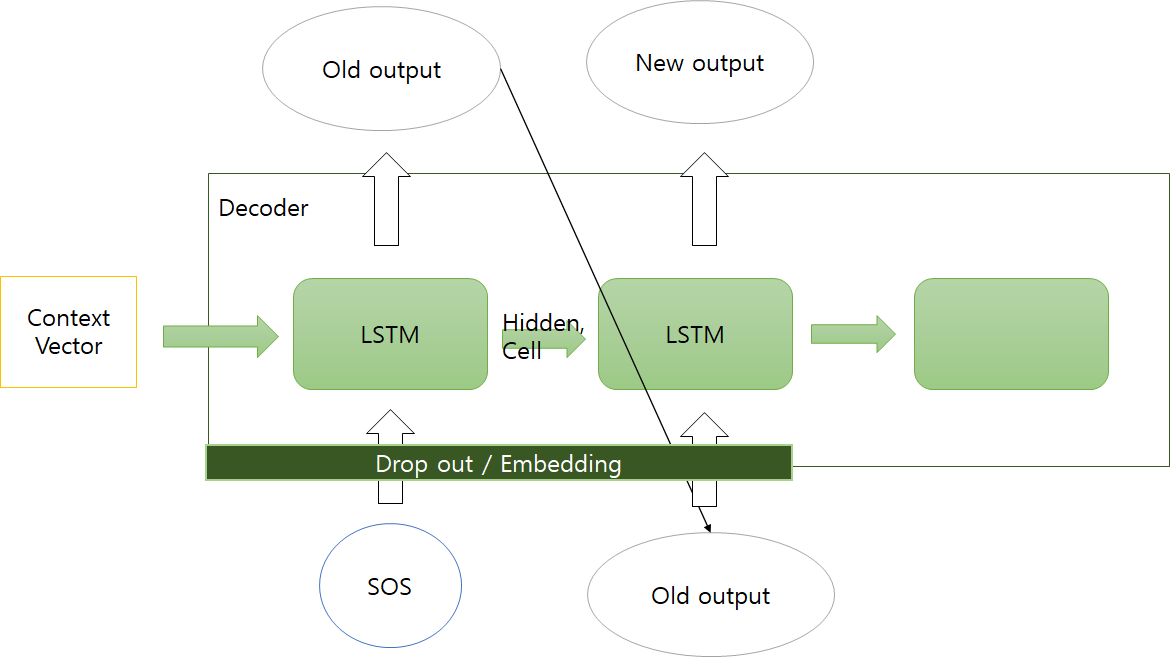

In [7]:
class Decoder(nn.Module):
  def __init__(self, out_dim, emb_dim, hid_dim, n_layers, drop_rate):
    super(Decoder, self).__init__()
    # arguments
    self.out_dim = out_dim
    self.emb_dim = emb_dim
    self.hid_dim = hid_dim
    self.n_layers = n_layers
    self.drop_rate = drop_rate

    # layers
    self.emb = nn.Embedding(self.out_dim, self.emb_dim)
    self.lstm = nn.LSTM(input_size = self.emb_dim,
                        hidden_size = self.hid_dim,
                        num_layers = self.n_layers,
                        batch_first = False,
                        dropout = self.drop_rate)
    self.dense = nn.Linear(self.hid_dim, self.out_dim)
    self.dropout = nn.Dropout(self.drop_rate)

  def forward(self, old_output, old_hidden, old_cell):  
    old_output = old_output.unsqueeze(0)    
    embedded = self.dropout(self.emb(old_output))
    new_output, (new_hidden, new_cell) = self.lstm(embedded, (old_hidden, old_cell)) 
    new_output = self.dense(new_output.squeeze(0))   
    return new_output, new_hidden, new_cell

Seq2Seq

In [8]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super(Seq2Seq, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device
   
  def forward(self, src, trg,teacher_forcing_ratio = 0.5):
      hidden, cell = self.encoder(src)
      trg_len = trg.shape[0]
      batch_size = trg.shape[1]
      trg_vocab_size = self.decoder.out_dim
      outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
      input_ = trg[0, :]
      for t in range(1, trg_len):
        output, hidden, cell = self.decoder(input_, hidden, cell)
        outputs[t] = output 
        top1 = output.argmax(1)
        teacher_force = random.random() < teacher_forcing_ratio
        input_ = trg[t] if teacher_force else top1
      return outputs

In [9]:
def init_uniform_weights(m, lower_bound = -0.08, upper_bound = 0.08):
  for name, param in m.named_parameters():
    nn.init.uniform_(param.data, lower_bound, upper_bound)

encoder = Encoder(INPUT_DIM, ENCODER_EMBED_DIM, HIDDEN_DIM, N_LAYERS, ENC_DROPOUT_RATIO)
decoder = Decoder(OUTPUT_DIM, DECODER_EMBED_DIM, HIDDEN_DIM, N_LAYERS, DEC_DROPOUT_RATIO)
model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_uniform_weights)

Seq2Seq(
  (encoder): Encoder(
    (emb): Embedding(7873, 256)
    (lstm): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (emb): Embedding(5893, 256)
    (lstm): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dense): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Trining Loop

In [10]:
class training:
  def __init__(self, SRC, TRG, encoder, decoder, model, lr):
    self.SRC = SRC
    self.TRG = TRG
    self.encoder = encoder
    self.decoder = decoder
    self.model = model
    self.lr = lr
    
    # Loss function - CE loss
    self.criterion =  nn.CrossEntropyLoss(ignore_index = self.TRG.vocab.stoi[self.TRG.pad_token])
    # optimizer - Adam
    self.opt = optim.Adam(self.model.parameters(), lr = self.lr)

  def train(self, iterator, clip, n_epoch = 10):
    self.model.train()
    start_time = time.time()
    for epoch in range(n_epoch):
      for idx, batch in enumerate(iterator):        
        # initilize
        src, trg = batch.src, batch.trg
        self.opt.zero_grad()
        # get output, trg
        output = self.model(src, trg)
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        # caculate loss
        loss = self.criterion(output, trg)
        loss.backward()
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), clip)
        # update
        self.opt.step()
        # print log        
        end_time = time.time()
        if idx %50 ==0 and idx>0:
          print(f'==== {epoch+1}/{n_epoch} epoch  {idx}-th batch =====')
          print(f'loss : {loss.item()}  time passed : {end_time - start_time}')

In [11]:
train_func = training(SRC, TRG, encoder, decoder, model, LR)
train_func.train(iterator = train_iterator, clip = CLIP, n_epoch = 10)

==== 1/10 epoch  51-th batch =====
loss : 5.682285308837891  time passed : 7.907276630401611
==== 1/10 epoch  101-th batch =====
loss : 5.219792366027832  time passed : 15.35661244392395
==== 1/10 epoch  151-th batch =====
loss : 5.083678722381592  time passed : 22.975640535354614
==== 1/10 epoch  201-th batch =====
loss : 5.043377876281738  time passed : 30.593381643295288
==== 2/10 epoch  51-th batch =====
loss : 5.079469680786133  time passed : 42.37563180923462
==== 2/10 epoch  101-th batch =====
loss : 4.962907314300537  time passed : 50.11170816421509
==== 2/10 epoch  151-th batch =====
loss : 5.005975723266602  time passed : 57.95673394203186
==== 2/10 epoch  201-th batch =====
loss : 5.006278038024902  time passed : 65.84492564201355
==== 3/10 epoch  51-th batch =====
loss : 4.879853248596191  time passed : 77.73311638832092
==== 3/10 epoch  101-th batch =====
loss : 5.024109363555908  time passed : 85.6799488067627
==== 3/10 epoch  151-th batch =====
loss : 4.864459991455078  

In [14]:
encoder = train_func.encoder
decoder = train_func.decoder
opt = train_func.opt
criterion  = train_func.criterion

torch.save({'Encoder' : encoder,
            'Decoder' : decoder,
            'Optimizer' : opt,
            'Criterion' : criterion}, './seq2seq.pt')